In [220]:
import pandas as pd
import spacy
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
tqdm.pandas()
from PIL import Image
import numpy as np

In [3]:
def tokenization(sentence:str, nlp=spacy.load('en_core_web_sm')) -> str :
    # Liste vide pour stocker les tokens
    token = []
    
    #drop #, @ & http
    sentence = re.sub('#[^\s]+', '', sentence)
    sentence = re.sub('@[^\s]+', '', sentence)
    sentence = re.sub('http[^\s]+', '', sentence) 
    
    # Suprimer les espaces consécutifs
    sentence = re.sub(r'\s+', ' ', sentence)

    # Récupéré les entitées
    for w in nlp(sentence).ents :
        token.append(w.text.replace(" ","_"))
        # Suprime l'entitée de la phrase
        sentence = sentence.replace(w.text, '')
    
    # Récupère les tokens dans la liste
    for w in nlp(sentence) :
        if not w.is_punct and not w.is_stop and w.text != ' ':
            token.append(w.lemma_)
    
    # Join la liste pour faire un str
    return " ".join(token)  

In [58]:
tweet_train = pd.read_csv('tweets/Corona_NLP_train.csv', encoding='latin1',dayfirst=True, parse_dates=['TweetAt'], usecols=['TweetAt','OriginalTweet','Sentiment'])
tweet_test = pd.read_csv('tweets/Corona_NLP_test.csv', encoding='latin1',dayfirst=True, parse_dates=['TweetAt'], usecols=['TweetAt','OriginalTweet','Sentiment'])

In [59]:
tweet_train.shape, tweet_train.shape

((41157, 3), (41157, 3))

In [60]:
(tweet_test.TweetAt.min(), tweet_test.TweetAt.max()), (tweet_train.TweetAt.min(), tweet_train.TweetAt.max())

((Timestamp('2020-03-02 00:00:00'), Timestamp('2020-03-16 00:00:00')),
 (Timestamp('2020-03-16 00:00:00'), Timestamp('2020-04-14 00:00:00')))

In [76]:
tweets = pd.concat([tweet_test, tweet_train], axis=0).reset_index(drop=True)

In [77]:
tweets.head()

,TweetAt,OriginalTweet,Sentiment
0,2020-03-02,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2020-03-02,When I couldn't find hand sanitizer at Fred Me...,Positive
2,2020-03-02,Find out how you can protect yourself and love...,Extremely Positive
3,2020-03-02,#Panic buying hits #NewYork City as anxious sh...,Negative
4,2020-03-03,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [78]:
hashtags = tweets.loc[:,'OriginalTweet'].str.findall('#[^\s]+').str.join(" ").str.replace(".","")
tweets.insert(3,"hashtags",hashtags)

In [79]:
mentions = tweets.loc[:,'OriginalTweet'].str.findall('@[^\s]+').str.join(" ").str.replace(".","")
tweets.insert(4,"mentions",mentions)

In [80]:
tweets.insert(5, 'nbr_link', tweets.loc[:, 'OriginalTweet'].str.findall('http[^\s]+').str.len())

In [13]:
clean_tweets = tweets.OriginalTweet.progress_apply(tokenization)

  0%|          | 0/44955 [00:00<?, ?it/s]

In [81]:
tweets.insert(6, 'clean_tweet', clean_tweets)

In [16]:
#tweets.to_csv('data/clean_tweets.csv', index=False)
#tweets = pd.read_csv('data/clean_tweets.csv')

In [82]:
tweets

,TweetAt,OriginalTweet,Sentiment,hashtags,mentions,nbr_link,clean_tweet
0,2020-03-02,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,#coronavirus-fearing,,2,New_Yorkers Wegmans Brooklyn FoodKick MaxDeliv...
1,2020-03-02,When I couldn't find hand sanitizer at Fred Me...,Positive,#Amazon #coronavirus,,1,Fred_Meyer 114.97 2 find hand sanitizer turn $...
2,2020-03-02,Find out how you can protect yourself and love...,Extremely Positive,#coronavirus,,0,find protect love one
3,2020-03-02,#Panic buying hits #NewYork City as anxious sh...,Negative,#Panic #NewYork #healthcare #BigApple #coronav...,,2,City 30s 1st buying hit anxious shopper stock ...
4,2020-03-03,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,#toiletpaper #dunnypaper #coronavirus #coronav...,,1,One_week buy baby milk powder buy toilet paper
...,...,...,...,...,...,...,...
44950,2020-04-14,Airline pilots offering to stock supermarket s...,Neutral,#NZ #COVID-19,,1,airline pilot offer stock supermarket shelf lo...
44951,2020-04-14,Response to complaint not provided citing COVI...,Extremely Negative,,,0,COVID-19 TAT response complaint provide cite r...
44952,2020-04-14,You know itÂs getting tough when @KameronWild...,Positive,#coronavirus #toiletpaper,@KameronWilds @kroger,0,know itâs get tough ration toilet paper marti...
44953,2020-04-14,Is it wrong that the smell of hand sanitizer i...,Neutral,#coronavirus #COVID19 #coronavirus,,0,wrong smell hand sanitizer start turn


In [290]:
all_hashtags= tweets.hashtags[(tweets.hashtags!= '')].str.split(" ").explode().str.lower()
all_hashtags[all_hashtags.str.contains("covid|corona")] = "Covid-19"
all_hashtags[all_hashtags.str.contains("toilet|paper")] = "ToiletPaperGate"

In [296]:
all_hashtags.to_csv('data/hashtags.csv', index=False)

In [294]:
all_mentions= tweets.mentions[tweets.mentions != ''].str.split(" ").explode().str.lower()

In [297]:
all_mentions.to_csv('data/mentions.csv', index=False)

In [245]:
mask = np.array(Image.open("coronavirus.png"))

In [259]:
def make_wordcloud(sentiment, cmap = plt.get_cmap('Greens')) :
    all_hashtags= tweets.hashtags[(tweets.hashtags!= '')&(tweets.Sentiment.str.contains(SENTIMENT))].str.split(" ").explode().str.replace('#',"").str.lower()
    all_hashtags[all_hashtags.str.contains("covid|corona")] = "Covid-19"
    all_hashtags[all_hashtags.str.contains("toilet|paper")] = "ToiletPaperGate"
    dict_hashtags = all_hashtags.value_counts(True).to_dict()
    wordcloud= WordCloud(width=1000, height=1000, background_color=(243, 243, 243), contour_width=5, colormap=cmap, mask=mask).generate_from_frequencies(dict_hashtags)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Masquer les axes
    plt.savefig(f'wordcloud/hashtags-{sentiment}.png',bbox_inches='tight', pad_inches=0)

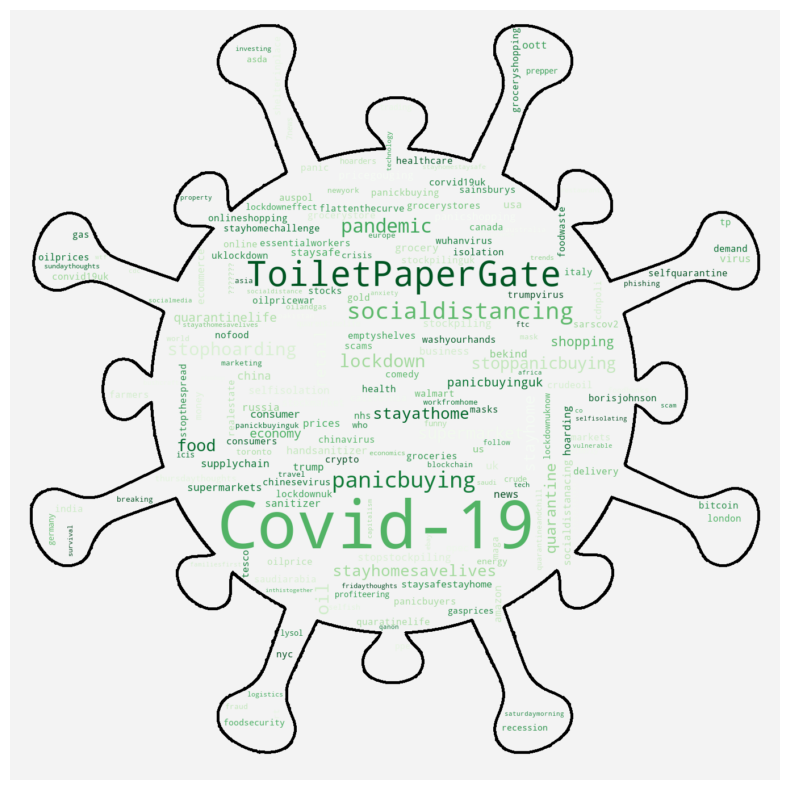

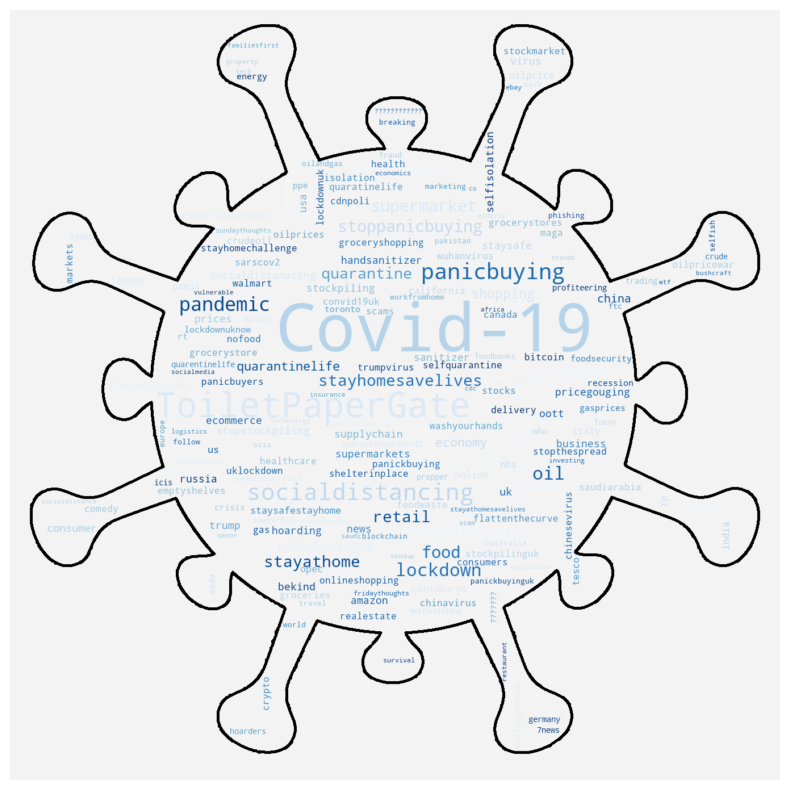

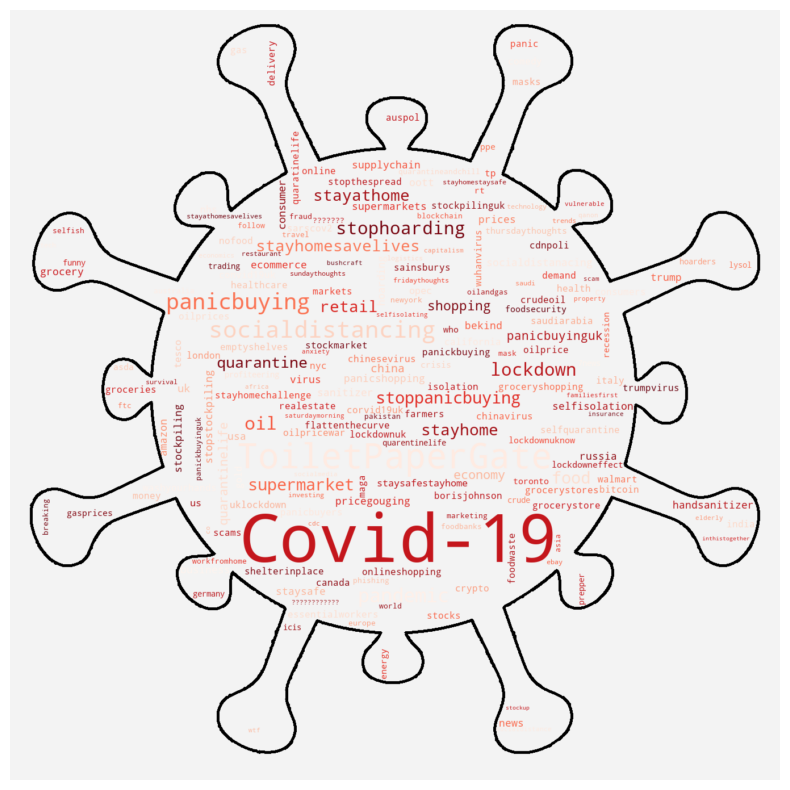

In [260]:
make_wordcloud('Positive')
make_wordcloud('Neutral', plt.get_cmap('Blues'))
make_wordcloud('Negative', plt.get_cmap('Reds'))

In [269]:
def make_wordcloud_metions(sentiment, cmap = plt.get_cmap('Greens')) :
    all_mentions= tweets.mentions[(tweets.mentions != '')&(tweets.Sentiment.str.contains(SENTIMENT))].str.split(" ").explode().str.replace('@',"").str.lower()
    dict_hashtags = all_mentions.value_counts(True).to_dict()
    wordcloud= WordCloud(width=100, height=100, background_color=(243, 243, 243), contour_width=5, colormap=cmap, mask=mask).generate_from_frequencies(dict_hashtags)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.savefig(f'wordcloud/mentions-{sentiment}.png',bbox_inches='tight', pad_inches=0)

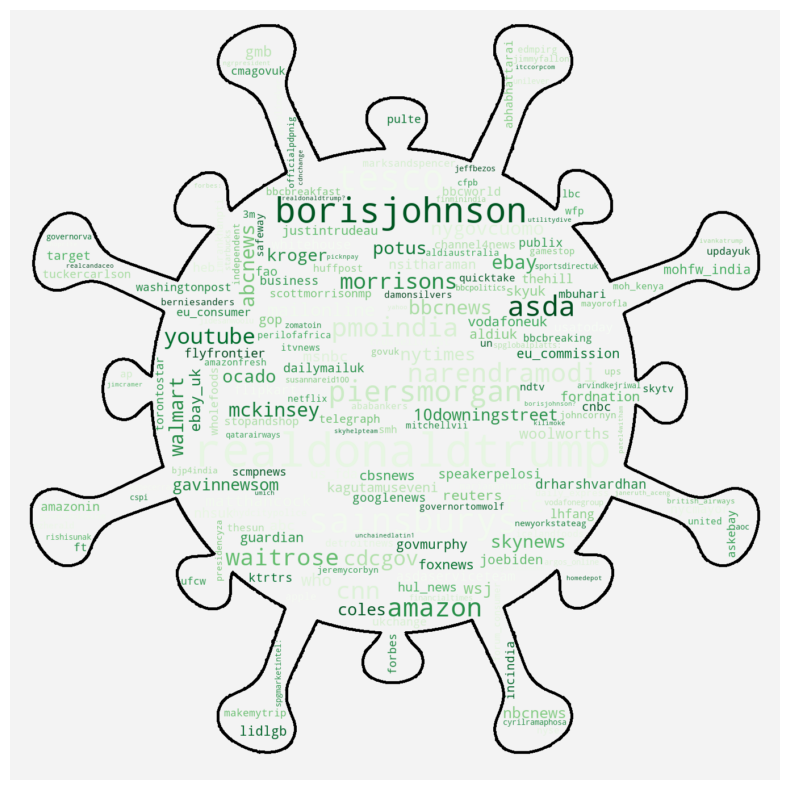

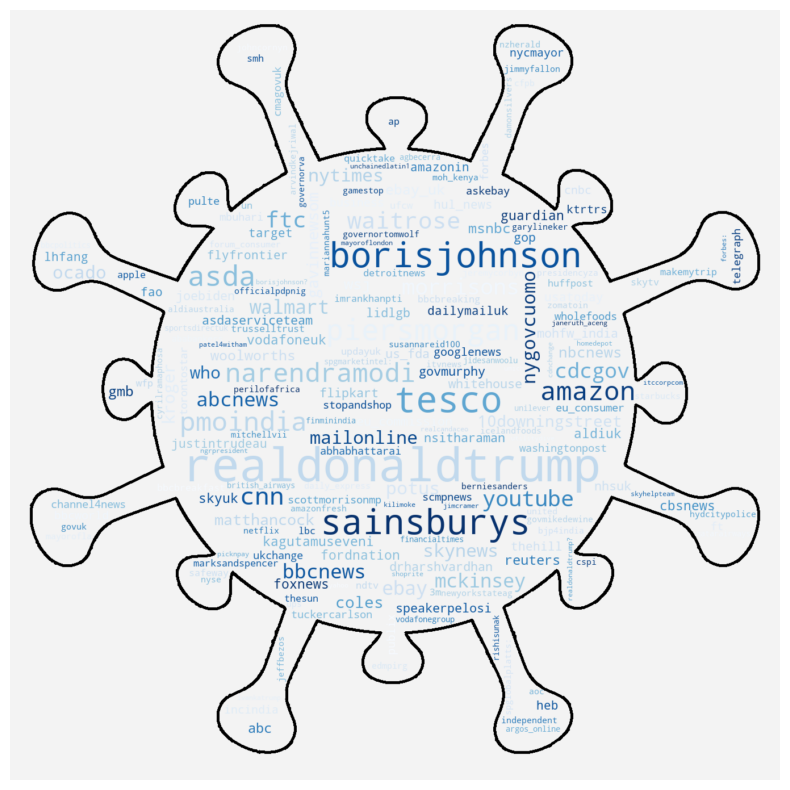

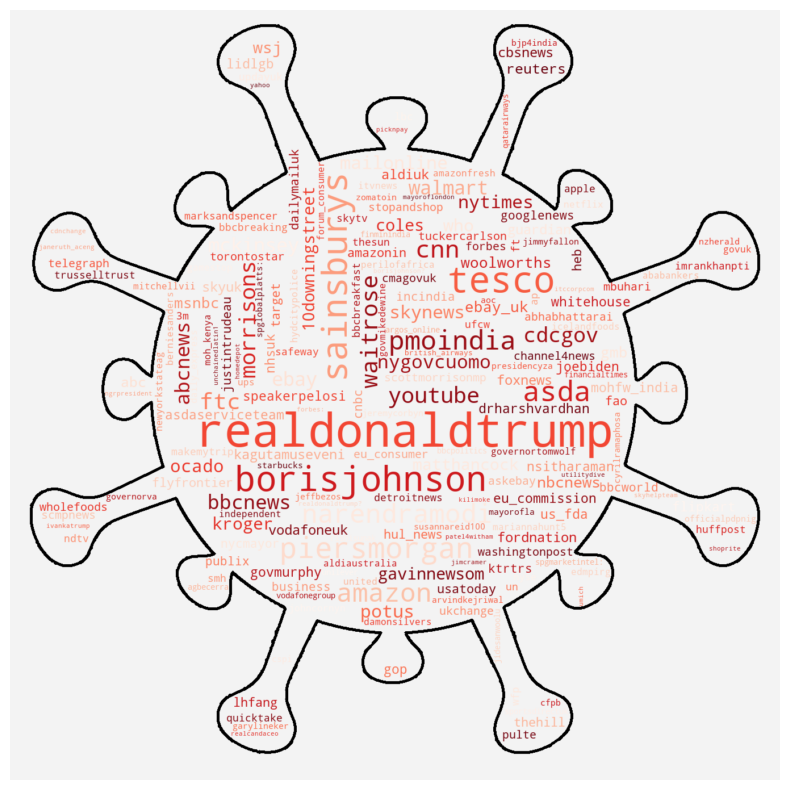

In [270]:
make_wordcloud_metions('Positive')
make_wordcloud_metions('Neutral', plt.get_cmap('Blues'))
make_wordcloud_metions('Negative', plt.get_cmap('Reds'))

In [276]:
tweets[['TweetAt','Sentiment']].to_csv('data/tweet_sentiment.csv', index=False)